In [72]:
import numpy as np

import torchaudio
import torch
import torch.nn.functional
import librosa
import matplotlib.pyplot as plt
import math


In [73]:
def wav_to_tensor(input_file_path, sampling_rate=12800):
  
    data, sr = librosa.load(input_file_path, sr=sampling_rate)
    
    tensor_data = torch.from_numpy(data).float()
    
    return tensor_data

input_file = 'SAMPLE/AD PE SGEAR IPA RH MODE1 MIC3 11_3_MDPS_30cm_S.wav'  # Adjust this to your text file path
tensor_data = wav_to_tensor(input_file)


In [1]:
def txt_to_tensor(input_file_path, sampling_rate=12800):
    # Read the data from the text file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    samples = []
    for line in lines:
        _, sample = line.split("\t")
        samples.append(float(sample))
    
    # Convert list to numpy array
    samples_array = np.array(samples, dtype=np.float32)
    
    # Convert numpy array to tensor
    tensor_data = torch.from_numpy(samples_array)
    
    return tensor_data



In [114]:
def perform_stft(waveform, n_fft=2048, win_length=None, hop_length=None, window_fn=torch.hann_window):
    waveform = waveform / math.sqrt(2)
    stft = torch.stft(waveform, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window_fn(n_fft), return_complex=True)
    stft = torch.abs(stft)
    #stft = librosa.amplitude_to_db(stft)
    return stft

stft_result = perform_stft(tensor_data)
stft_result = (stft_result * 50000).log10()
stft_result = 20 * stft_result

#stft_result = torch.from_numpy(stft_result)
stft_result.shape

torch.Size([1025, 380])

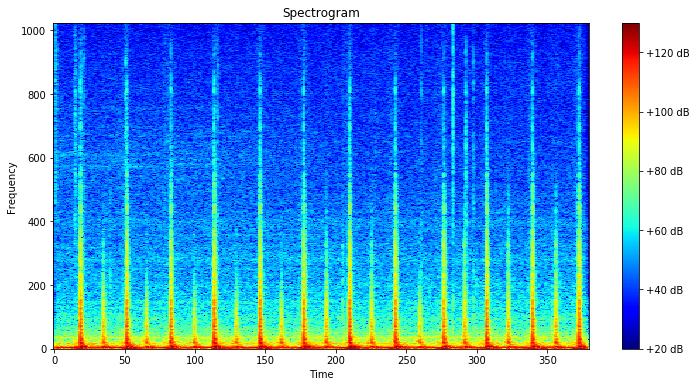

In [115]:
plt.figure(figsize=(12, 6))
plt.imshow(stft_result, aspect='auto', origin='lower', cmap='jet',vmin=20, vmax=130)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

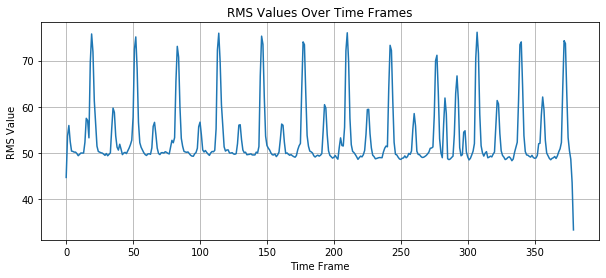

In [116]:
def calculate_sum_of_squares(stft_result):
    # STFT 결과의 크기를 구합니다
    amplitude = torch.abs(stft_result)
    
    # 각 시간 프레임에 대한 제곱합을 계산하고 루트를 씌웁니다
    sum_of_squares = torch.sqrt(torch.sum(amplitude ** 2, dim=0))
    
    return sum_of_squares

rms_values = calculate_rms(stft_result)

plt.figure(figsize=(10, 4))
plt.plot(rms_values.numpy())
plt.title('RMS Values Over Time Frames')
plt.xlabel('Time Frame')
plt.ylabel('RMS Value')
plt.grid()
plt.show()

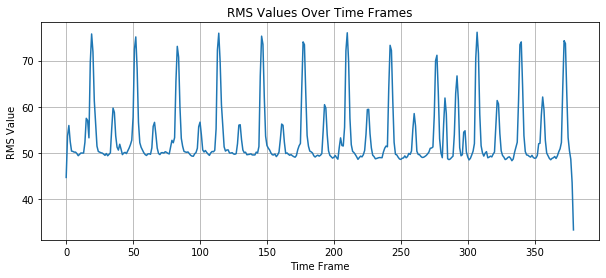

In [117]:
import torch
import matplotlib.pyplot as plt

def calculate_rms(stft_result):
    # STFT 결과의 크기를 구합니다
    amplitude = torch.abs(stft_result)
    
    # 각 시간 프레임에 대한 RMS 값을 계산합니다
    rms_values = torch.sqrt(torch.mean(amplitude ** 2, dim=0))
    
    return rms_values

rms_values = calculate_rms(stft_result)

plt.figure(figsize=(10, 4))
plt.plot(rms_values.numpy())
plt.title('RMS Values Over Time Frames')
plt.xlabel('Time Frame')
plt.ylabel('RMS Value')
plt.grid()
plt.show()

In [118]:
def apply_a_weighting_librosa(stft_result, sample_rate):

    freqs = np.linspace(0, sample_rate / 2, stft_result.size(0))
    
    a_weighting_db = librosa.A_weighting(freqs)
    
    a_weighting_db_tensor = torch.from_numpy(a_weighting_db).to(stft_result.dtype)
    
    a_weighted_stft = stft_result + a_weighting_db_tensor.unsqueeze(1)  
    #a_weighted_stft = stft_result * a_weighting_db_tensor.unsqueeze(1)  # 주파수 차원에 적용

    return a_weighted_stft

sample_rate = 12800  

a_weighted_result = apply_a_weighting_librosa(stft_result, sample_rate)

print(a_weighted_result.shape) 


torch.Size([1025, 380])


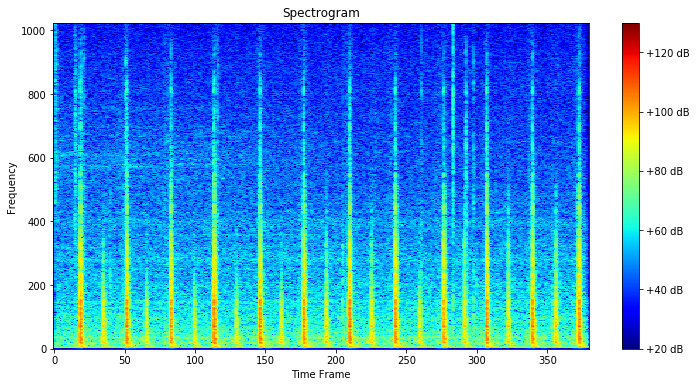

In [119]:

plt.figure(figsize=(12, 6))
plt.imshow(a_weighted_result.numpy(), aspect='auto', origin='lower', cmap='jet',vmin=20, vmax=130)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency')
plt.show()

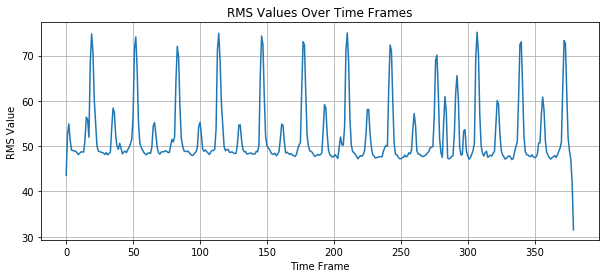

In [122]:
def calculate_sum_of_squares(stft_result):
    # STFT 결과의 크기를 구합니다
    amplitude = torch.abs(stft_result)
    
    # 각 시간 프레임에 대한 제곱합을 계산하고 루트를 씌웁니다
    sum_of_squares = torch.sqrt(torch.sum(amplitude ** 2, dim=0))
    
    return sum_of_squares

rms_values = calculate_rms(a_weighted_result)

plt.figure(figsize=(10, 4))
plt.plot(rms_values.numpy())
plt.title('RMS Values Over Time Frames')
plt.xlabel('Time Frame')
plt.ylabel('RMS Value')
plt.grid()
plt.show()

[Text(0, 0.5, 'Weighting (log10)'),
 Text(0.5, 0, 'Frequency (Hz)'),
 Text(0.5, 1.0, 'A-Weighting of CQT frequencies')]

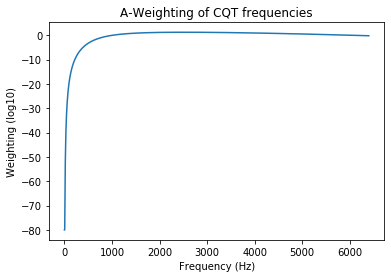

In [120]:
import matplotlib.pyplot as plt
freqs = np.linspace(0, sample_rate / 2, stft_result.size(0))
weights = librosa.A_weighting(freqs)
weights = torch.from_numpy(weights).to(stft_result.dtype)
fig, ax = plt.subplots()
ax.plot(freqs, weights)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Weighting (log10)',
       title='A-Weighting of CQT frequencies')

In [8]:
weights.shape

torch.Size([1025])